In [1]:
# Importing Libraries
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [4]:
# Establishing connection with google drive
# from google.colab import drive
# drive.mount('/content/drive')
import os
color_dataset_path = '/kaggle/input/satellite-images/EuroSAT'  # Base path for colorised images
gray_scale_dataset_path = '/kaggle/input/satellite-images/EuroSAT_gray_scale'  # Base path for grayscale images
if not os.path.exists(gray_scale_dataset_path):
    os.makedirs(gray_scale_dataset_path)

# List of folders representing different classes
class_folders = ['River', 'SeaLake', 'Residential', 'Pasture', 'AnnualCrop','Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'PermanentCrop']

In [ ]:
import os
import subprocess

# Install unrar (only necessary if not already installed)
# !apt-get install unrar

# Define paths for the uploaded rar files
color_dataset_rar = '/kaggle/input/satellite-images/EuroSAT'
gray_scale_dataset_rar = '/kaggle/input/satellite-images/EuroSAT_gray_scale'

# Define paths for extracted datasets
color_dataset_path = 'EuroSAT'  # Directory for color images
gray_scale_dataset_path = 'EuroSAT_gray_scale'  # Directory for grayscale images

# Extract the color dataset if the rar file exists and not extracted yet
if not os.path.exists(color_dataset_path):
    os.makedirs(color_dataset_path)
    subprocess.run(['unrar', 'x', color_dataset_rar, color_dataset_path])
    print(f"{color_dataset_rar} extracted to {color_dataset_path}")

# Extract the grayscale dataset if the rar file exists and not extracted yet
if not os.path.exists(gray_scale_dataset_path):
    os.makedirs(gray_scale_dataset_path)
    subprocess.run(['unrar', 'x', gray_scale_dataset_rar, gray_scale_dataset_path])
    print(f"{gray_scale_dataset_rar} extracted to {gray_scale_dataset_path}")

# List of folders representing different classes
class_folders = ['River', 'SeaLake', 'Residential', 'Pasture', 'AnnualCrop',
                 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'PermanentCrop']

In [5]:
print("Folders in color dataset:")
for folder in os.listdir(color_dataset_path):
    if os.path.isdir(os.path.join(color_dataset_path, folder)):
        print(folder)

# Print all folders in the grayscale dataset
print("\nFolders in grayscale dataset:")
for folder in os.listdir(gray_scale_dataset_path):
    if os.path.isdir(os.path.join(gray_scale_dataset_path, folder)):
        print(folder)

Folders in color dataset:
SeaLake
Highway
River
Pasture
Industrial
Residential
PermanentCrop
AnnualCrop
Forest
HerbaceousVegetation

Folders in grayscale dataset:
Industrial_gray_scale
SeaLake_gray_scale
River_gray_scale
AnnualCrop_gray_scale
Residential_gray_scale
PermanentCrop_gray_scale
HerbaceousVegetation_gray_scale
Pasture_gray_scale
Forest_gray_scale
Highway_gray_scale


In [ ]:
# Function to convert RGB Image to GrayScale
def convert_to_grayscale(image_path, output_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Unable to load image at {image_path}")
        return

    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    cv2.imwrite(output_path, gray_image)

In [ ]:
# Convert all images to GrayScale
for folder in class_folders:
    source_folder = os.path.join(color_dataset_path, folder)
    dest_folder = os.path.join(gray_scale_dataset_path, f"{folder}_gray_scale")

    if not os.path.exists(source_folder):
        print(f"Warning: Source folder {source_folder} does not exist. Skipping...")
        continue

    if not os.path.exists(dest_folder):
        os.makedirs(dest_folder)

    for filename in os.listdir(source_folder):
        image_path = os.path.join(source_folder, filename)
        output_path = os.path.join(dest_folder, filename)
        convert_to_grayscale(image_path, output_path)

print("\nGrayscale conversion completed!")



Grayscale conversion completed!


In [6]:
# Function to load and preprocess images from directories
def load_data(color_dataset_path, gray_scale_dataset_path, class_folders, size=(64, 64)):
    X = []  # Grayscale images
    Y = []  # Color images

    for folder in class_folders:
        color_folder = os.path.join(color_dataset_path, folder)
        gray_folder = os.path.join(gray_scale_dataset_path, f"{folder}_gray_scale")

        if not os.path.exists(color_folder) or not os.path.exists(gray_folder):
            print(f"Skipping missing folder: {color_folder} or {gray_folder}")
            continue

        # List all files in the color and grayscale folder
        color_files = os.listdir(color_folder)
        gray_files = os.listdir(gray_folder)

        for filename in color_files:
            color_path = os.path.join(color_folder, filename)
            gray_path = os.path.join(gray_folder, filename)

            if not os.path.isfile(color_path) or not os.path.isfile(gray_path):
                print(f"Skipping missing files: {color_path} or {gray_path}")
                continue

            color_img = cv2.imread(color_path)
            gray_img = cv2.imread(gray_path, cv2.IMREAD_GRAYSCALE)

            if color_img is None or gray_img is None:
                print(f"Error loading images: {color_path} or {gray_path}")
                continue

            # Resize images to the desired size (128x128)
            color_img = cv2.resize(color_img, size)
            gray_img = cv2.resize(gray_img, size)

            # Expand dimensions of grayscale image to (height, width, 1)
            gray_img = np.expand_dims(gray_img, axis=-1)

            # Normalize pixel values to [0, 1]
            X.append(gray_img / 255.0)  # Grayscale images
            Y.append(color_img / 255.0)  # Color images

    return np.array(X), np.array(Y)

In [7]:
from tensorflow.keras.layers import MaxPooling2D, UpSampling2D, Concatenate

# Define U-Net architecture for colorization
def build_colorization_model(input_shape):
    inputs = Input(shape=input_shape)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    # Bottleneck
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)

    # Decoder
    u5 = UpSampling2D((2, 2))(c4)
    u5 = Concatenate()([u5, c3])
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(u5)
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(c5)

    u6 = UpSampling2D((2, 2))(c5)
    u6 = Concatenate()([u6, c2])
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = Concatenate()([u7, c1])
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(c7)

    outputs = Conv2D(3, (1, 1), activation='sigmoid')(c7)  # 3 channels for RGB color

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [ ]:
import tensorflow as tf

# Check if GPU is available
if tf.test.gpu_device_name():
    print(f"GPU device found: {tf.test.gpu_device_name()}")
else:
    print("No GPU device found. Make sure you've enabled GPU in your Colab runtime settings.")

# Assuming load_data is a function that loads and processes your dataset
X, Y = load_data(color_dataset_path, gray_scale_dataset_path, class_folders, size=(64, 64))

# Split the data into training and validation sets
X_train, X_val = X[:int(0.8*len(X))], X[int(0.8*len(X)):]
Y_train, Y_val = Y[:int(0.8*len(Y))], Y[int(0.8*len(Y)):]

# Define the model (assuming 'model' is already defined)
try:
    # Set up a strategy to use GPU if available
    strategy = tf.distribute.MirroredStrategy()
    with strategy.scope():
        # Train the model
        history = model.fit(X_train, Y_train, batch_size=16, epochs=2, validation_data=(X_val, Y_val))

        # Save model weights with the correct filename
        # weights_path = '/content/drive/MyDrive/colorization_model_weights.weights.h5'
        # model.save_weights(weights_path)
        weights_path = '/content/colorization_model_weights.weights.h5'
        model.save_weights(weights_path)
        print(f"Model weights saved successfully to {weights_path}.")

except Exception as e:
    print(f"Error during training: {e}")


In [8]:
# Load and Split the data into training and validation sets
X, Y = load_data(color_dataset_path, gray_scale_dataset_path, class_folders, size=(64, 64))
X_train, X_val = X[:int(0.8*len(X))], X[int(0.8*len(X)):]
Y_train, Y_val = Y[:int(0.8*len(Y))], Y[int(0.8*len(Y)):]

In [9]:
print(f"Shape of X (grayscale images): {X.shape}")
print(f"Shape of Y (color images): {Y.shape}")


Shape of X (grayscale images): (27000, 64, 64, 1)
Shape of Y (color images): (27000, 64, 64, 3)


In [30]:
X[0].shape

(64, 64, 1)

In [10]:
# Build and compile the model
input_shape = (64, 64, 1)  # (height, width, channels)
model = build_colorization_model(input_shape)
model.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['accuracy'])

In [11]:
# Train the model
try:
    history = model.fit(X_train, Y_train, batch_size=16, epochs=50, validation_data=(X_val, Y_val))

    # Save model weights with correct filename
    # weights_path = '/content/drive/MyDrive/colorization_model_weights.weights.h5'
    # model.save_weights(weights_path)
    weights_path = '/content/colorization_model_weights.weights.h5'
    model.save_weights(weights_path)
    print(f"Model weights saved successfully to {weights_path}.")

except Exception as e:
    print(f"Error during training: {e}")

Epoch 1/50


I0000 00:00:1725733334.014255     113 service.cc:145] XLA service 0x78c5b4002c60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725733334.014336     113 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1725733334.014341     113 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


   3/1350 ━━━━━━━━━━━━━━━━━━━━ 1:23 62ms/step - accuracy: 0.4092 - loss: 0.0453 

I0000 00:00:1725733344.249172     113 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1350/1350 ━━━━━━━━━━━━━━━━━━━━ 78s 47ms/step - accuracy: 0.7894 - loss: 0.0055 - val_accuracy: 0.7558 - val_loss: 0.0013
Epoch 2/50
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 64s 47ms/step - accuracy: 0.8332 - loss: 7.9572e-04 - val_accuracy: 0.7520 - val_loss: 0.0014
Epoch 3/50
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 64s 47ms/step - accuracy: 0.8387 - loss: 7.6918e-04 - val_accuracy: 0.7582 - val_loss: 0.0010
Epoch 4/50
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 64s 48ms/step - accuracy: 0.8388 - loss: 7.4392e-04 - val_accuracy: 0.7521 - val_loss: 0.0012
Epoch 5/50
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 64s 47ms/step - accuracy: 0.8400 - loss: 7.3922e-04 - val_accuracy: 0.7521 - val_loss: 0.0010
Epoch 6/50
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 64s 48ms/step - accuracy: 0.8363 - loss: 7.0318e-04 - val_accuracy: 0.7667 - val_loss: 0.0012
Epoch 7/50
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 64s 47ms/step - accuracy: 0.8378 - loss: 6.9520e-04 - val_accuracy: 0.7569 - val_loss: 0.0010
Epoch 8/50
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 64s 47ms/step - accur

In [13]:
# Evaluate the model on the validation set and test accuracy
val_loss, val_accuracy = model.evaluate(X_val, Y_val)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.7972 - loss: 7.7784e-04
Validation Loss: 0.0007753717363812029
Validation Accuracy: 0.7953450679779053


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


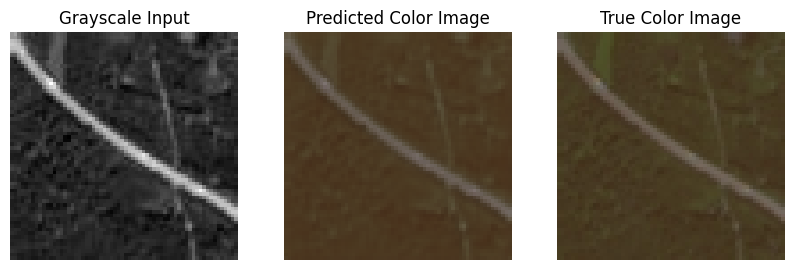

In [15]:
# Test function to visualize predictions
def test_model(model, X_val, Y_val, index=0):
    # Get the grayscale input and actual color image
    grayscale_img = X_val[index]
    true_color_img = Y_val[index]

    # Add batch dimension (1, 64, 64, 1) for model prediction
    grayscale_img_batch = np.expand_dims(grayscale_img, axis=0)

    # Predict the colorized image
    predicted_color_img = model.predict(grayscale_img_batch)[0]  # Remove batch dimension after prediction

    # Rescale from [0, 1] to [0, 255] for display purposes
    predicted_color_img = (predicted_color_img * 255).astype(np.uint8)
    true_color_img = (true_color_img * 255).astype(np.uint8)
    grayscale_img = (grayscale_img.squeeze() * 255).astype(np.uint8)

    # Display images for comparison
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 3, 1)
    plt.title("Grayscale Input")
    plt.imshow(grayscale_img, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Predicted Color Image")
    plt.imshow(predicted_color_img)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("True Color Image")
    plt.imshow(true_color_img)
    plt.axis('off')

    plt.show()

# Test the model on one sample from validation set
test_model(model, X_val, Y_val, index=0)